In [37]:
import os
from PIL import Image, ImageFilter
import numpy as np
import random

# Binarization
def binarize_image(image):
    img = image.convert('L')  # Convert image to grayscale
    # Binarize using a threshold
    threshold = 128
    binary_img = img.point(lambda p: 255 if p > threshold else 0)
    return binary_img

# Deskewing
def deskew_image(image):
    # Convert to NumPy array
    img_array = np.array(image)

    # Find the coordinates of the black (non-background) pixels
    coords = np.column_stack(np.where(img_array == 0))
    if len(coords) == 0:
        return image  # If there are no black pixels, return the original image

    # Calculate the angle of skew
    angle = np.rad2deg(np.arctan2(coords[:, 1].mean() - img_array.shape[0] / 2, coords[:, 0].mean() - img_array.shape[1] / 2))

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotate the image
    pil_image = image.rotate(angle, expand=True)  # Use PIL to rotate
    return pil_image

# Noise removal
def remove_noise(image):
    # Apply a Gaussian blur to reduce noise
    denoised_image = image.filter(ImageFilter.GaussianBlur(radius=1))
    return denoised_image

# Preprocess an image
def preprocess_image(img):
    if isinstance(img, str):  # If the input is a file path, open the image
        img = Image.open(img)

    # Binarize the image (assuming this function is defined)
    binary_img = binarize_image(img)

    # Deskew the image (assuming this function is defined)
    deskewed_img = deskew_image(binary_img)

    # Resize the image to a fixed size (for example 1024x1024)
    resized_img = deskewed_img.resize((1024, 1024))

    return resized_img


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import random

# Load and preprocess data
def load_washington_data(images_folder, transcription_file):
    images = []
    transcriptions = []

    # Load images as PIL Image objects
    for filename in os.listdir(images_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(images_folder, filename)
            img = Image.open(img_path)  # Open image using PIL
            images.append(img)

    # Load transcriptions
    with open(transcription_file, 'r') as f:
        transcriptions = [line.strip() for line in f.readlines()]

    return images, transcriptions

# Define the AdvancedAugmentation class
class AdvancedAugmentation:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomRotation(15),  # Rotate images randomly within a 15-degree range
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation, and hue
            transforms.RandomAffine(translate=(0.1, 0.1), degrees=10, shear=10)  # Random affine transformations
        ])

    def __call__(self, img):
        return self.transforms(img)

# Function to augment images
def augment_images_with_labels(images, transcriptions):
    augmented_images = []
    augmented_transcriptions = []

    # Initialize the advanced augmentation
    augmentation = AdvancedAugmentation()

    for img, transcription in zip(images, transcriptions):
        augmented = augmentation(img)  # Apply the advanced augmentation to the image
        augmented_images.append(augmented)
        augmented_transcriptions.append(transcription)  # Keep the original transcription for augmented image

    return augmented_images, augmented_transcriptions

# Split the data into train, validation, and test sets
def split_data(images, transcriptions, train_ratio=0.7, val_ratio=0.15):
    total_size = len(images)
    indices = list(range(total_size))
    random.shuffle(indices)

    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    train_images = [images[i] for i in train_indices]
    train_transcriptions = [transcriptions[i] for i in train_indices]

    val_images = [images[i] for i in val_indices]
    val_transcriptions = [transcriptions[i] for i in val_indices]

    test_images = [images[i] for i in test_indices]
    test_transcriptions = [transcriptions[i] for i in test_indices]

    return (train_images, train_transcriptions), (val_images, val_transcriptions), (test_images, test_transcriptions)


In [74]:
print(len(train_images))
print(len(val_images))
print(len(test_images))

918
196
198


In [40]:
!pip install pytesseract

In [41]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import cv2
import torch.nn.functional as F


# UNet model with fewer layers in the encoder and decoder
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch, dropout_prob=0.5):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),  # Add padding to maintain size
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch),  # Batch Normalization
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),  # Add padding to maintain size
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch),  # Batch Normalization
                nn.Dropout2d(dropout_prob)  # Dropout with 50% probability
            )

        # Reduced layers: fewer encoders and decoders
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)  # Final layer

    def forward(self, x):

        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))

        bottleneck = self.bottleneck(self.pool(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.out_conv(dec1)

        # Optionally, clamp output to valid range

        return out

def modify_resnet_for_grayscale(resnet_model):
    # Modify the first convolutional layer of ResNet-18 to accept 1 channel
    resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return resnet_model

class OCRModel(nn.Module):
    def __init__(self, num_classes, hidden_size=128, num_layers=2, dropout_rate=0.5):
        super(OCRModel, self).__init__()

        # Load ResNet-18 and modify it for grayscale input
        resnet = models.resnet18(pretrained=True)
        resnet = modify_resnet_for_grayscale(resnet)  # Modify ResNet for grayscale

        # Freeze the parameters in the ResNet layers except the final layer
        for name, param in resnet.named_parameters():
            if 'conv1' not in name:
                param.requires_grad = False

        # Remove the fully connected layer from ResNet
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        self.combining_conv = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(512)  # Add BatchNorm
        self.relu = nn.ReLU()
        self.pooling = nn.AdaptiveAvgPool2d((32, 32))  # Further reduces dimensions

        # Dropout after feature extraction and convolution
        self.feature_dropout = nn.Dropout2d(dropout_rate)  # Dropout for 2D features

        # Sequence modeling using LSTM
        self.rnn = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)

        # Dropout after LSTM
        self.rnn_dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Extract features using ResNet
        features = self.feature_extractor(x)
        features = F.normalize(features, p=2, dim=1)  # Normalize features

        features = F.interpolate(features, size=(128, 128), mode="bilinear", align_corners=False)
        features = self.combining_conv(features)
        features = self.batch_norm(features)  # Batch normalization
        features = self.relu(features)
        features = self.pooling(features)  # Reduce spatial dimensions

        # Apply dropout after the feature extraction
        features = self.feature_dropout(features)

        # Reshape features for LSTM input
        B, C, H, W = features.size()
        features = features.view(B, H * W, C)

        # Sequence modeling with LSTM
        rnn_out, _ = self.rnn(features)

        # Apply dropout after LSTM
        rnn_out = self.rnn_dropout(rnn_out)

        # Classify with a fully connected layer
        logits = self.fc(rnn_out)

        return logits

# Example usage:
num_classes = 97  # Adjust to your specific number of classes
model = OCRModel(num_classes=num_classes, dropout_rate=0.5)  # Set dropout rate as needed

# Example input (batch_size, channels, height, width)
input_tensor = torch.randn(16, 1, 128, 128)  # Batch size of 16, grayscale images of 128x128

# Forward pass
output = model(input_tensor)
print(output.shape)  # Should output (batch_size, sequence_length, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 1024, 97])


In [42]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split

# Main workflow
images_folder = '/content/drive/My Drive/washingtondb-v1.0/data/line_images_normalized'
transcription_file = '/content/drive/My Drive/washingtondb-v1.0/ground_truth/transcription.txt'

# Load data
images, transcriptions = load_washington_data(images_folder, transcription_file)

# Preprocess images
preprocessed_images = [preprocess_image(img) for img in images]

# Augment data
augmented_images, augmented_transcriptions = augment_images_with_labels(preprocessed_images, transcriptions)
all_images = preprocessed_images + augmented_images
all_transcriptions = transcriptions * 2  # Duplicate transcriptions for augmented data

# Split data
(train_images, train_transcriptions), (val_images, val_transcriptions), (test_images, test_transcriptions) = split_data(all_images, all_transcriptions)

In [43]:
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Washington Dataset Loader (fixed for preprocessed data)
from PIL import Image

class WashingtonDataset(Dataset):
    def __init__(self, images, transcriptions=None, masks=None, transform=None):
        """
        Initialize the dataset with preprocessed images, masks, and transcriptions.
        """
        self.images = images
        self.transcriptions = transcriptions
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve an image, its mask, and its transcription.
        """
        # Retrieve image
        image = self.images[idx]
        image = image.convert('L')  # 'L' mode for grayscale

        # Retrieve corresponding transcription
        transcription = self.transcriptions[idx] if self.transcriptions else None

        # Retrieve mask
        mask = self.masks[idx] if self.masks is not None else None

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            if mask is not None:
                mask = self.transform(mask)

        return image, mask, transcription  # Include transcription


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize((128, 128)),  # Resize the image to fit the model input
])

# Generate synthetic masks (e.g., random binary masks)
def generate_random_mask(image):
    width, height = image.size
    mask = np.random.randint(0, 2, (height, width), dtype=np.uint8)  # Random binary mask
    mask = Image.fromarray(mask * 255)  # Convert to PIL Image with 0/255 values
    #mask = mask.filter(ImageFilter.GaussianBlur(radius=2))  # Adjust radius for strength of blur
    return mask

# Generate masks for all images
train_masks = [generate_random_mask(image) for image in train_images]
val_masks = [generate_random_mask(image) for image in val_images]
test_masks = [generate_random_mask(image) for image in test_images]

# Create datasets with preprocessed images and transcriptions
train_dataset = WashingtonDataset(train_images, train_transcriptions, train_masks, transform=transform)
val_dataset = WashingtonDataset(val_images, val_transcriptions, val_masks, transform=transform)
test_dataset = WashingtonDataset(test_images, test_transcriptions, test_masks, transform=transform)

# Create DataLoaders
batch_size = 16  # Adjust based on your system's capacity

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

# Initialize UNet
unet = UNet(in_channels=1, out_channels=1)  # Binary segmentation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet = unet.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=1e-5)  # Adding L2 regularization
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  # Reduce LR every 5 epochs

# Training and Validation loop
for epoch in range(10):  # Example: 10 epochs
    unet.train()
    epoch_train_loss = 0
    for images, masks, _ in train_loader:  # Ignore transcription for training
        images, masks = images.to(device), masks.to(device)

        # Ensure masks have correct shape
        if masks.ndimension() == 3:
            masks = masks.unsqueeze(1)

        # Forward pass
        outputs = unet(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Validation phase
    unet.eval()  # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad():  # No gradients are needed during validation
        for images, masks, _ in val_loader:  # Assuming val_loader is defined for validation data
            images, masks = images.to(device), masks.to(device)

            # Ensure masks have correct shape
            if masks.ndimension() == 3:
                masks = masks.unsqueeze(1)

            # Forward pass
            outputs = unet(images)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()

    # Calculate average losses for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    # Print results for this epoch
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

# Save the trained model
torch.save(unet.state_dict(), "unet_text_region_detection.pth")


Epoch 1, Train Loss: 0.7432, Validation Loss: 0.6942
Epoch 2, Train Loss: 0.7284, Validation Loss: 0.6947
Epoch 3, Train Loss: 0.7189, Validation Loss: 0.6939
Epoch 4, Train Loss: 0.7172, Validation Loss: 0.6936
Epoch 5, Train Loss: 0.7136, Validation Loss: 0.6936
Epoch 6, Train Loss: 0.7141, Validation Loss: 0.6936
Epoch 7, Train Loss: 0.7129, Validation Loss: 0.6938
Epoch 8, Train Loss: 0.7115, Validation Loss: 0.6933
Epoch 9, Train Loss: 0.7097, Validation Loss: 0.6934
Epoch 10, Train Loss: 0.7078, Validation Loss: 0.6933


In [45]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
unet.eval()

# Initialize accumulators for metrics
total_accuracy = 0.0
total_precision = 0.0
total_recall = 0.0
total_f1 = 0.0
total_batches = 0

# No gradient calculation for evaluation
with torch.no_grad():
    for images, masks, _ in val_loader:  # Iterate over the validation data loader
        # Move images and masks to the appropriate device
        images, masks = images.to(device), masks.to(device)

        # Forward pass through the U-Net model and apply sigmoid activation
        outputs = torch.sigmoid(unet(images))

        # Convert probabilities to binary predictions (threshold = 0.5)
        preds = (outputs > 0.5).float()

        # Flatten predictions and masks for metric calculations
        preds_flat = preds.view(-1).cpu().numpy()
        masks_flat = masks.view(-1).cpu().numpy()

        # Ensure masks are binary (0 or 1)
        masks_flat = (masks_flat > 0.5).astype(int)

        # Compute metrics for this batch
        batch_accuracy = accuracy_score(masks_flat, preds_flat)
        batch_precision = precision_score(masks_flat, preds_flat, zero_division=0)
        batch_recall = recall_score(masks_flat, preds_flat, zero_division=0)
        batch_f1 = f1_score(masks_flat, preds_flat, zero_division=0)

        # Accumulate metrics
        total_accuracy += batch_accuracy
        total_precision += batch_precision
        total_recall += batch_recall
        total_f1 += batch_f1
        total_batches += 1

# Compute average metrics over all batches
average_accuracy = total_accuracy / total_batches
average_precision = total_precision / total_batches
average_recall = total_recall / total_batches
average_f1 = total_f1 / total_batches

# Print the results
print(f"Validation Accuracy: {average_accuracy:.2f}")
print(f"Validation Precision: {average_precision:.2f}")
print(f"Validation Recall: {average_recall:.2f}")
print(f"Validation F1 Score: {average_f1:.2f}")



Validation Accuracy: 0.50
Validation Precision: 0.50
Validation Recall: 0.81
Validation F1 Score: 0.62


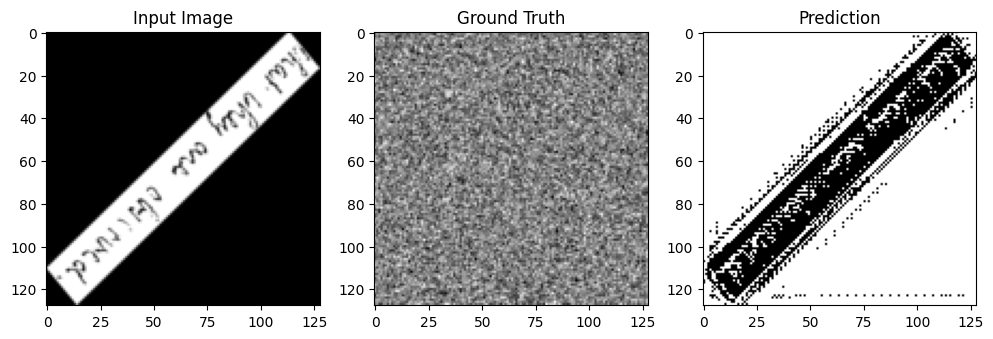

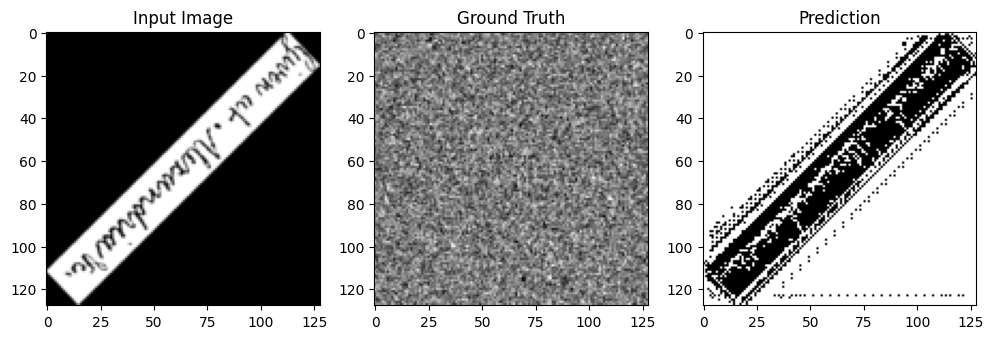

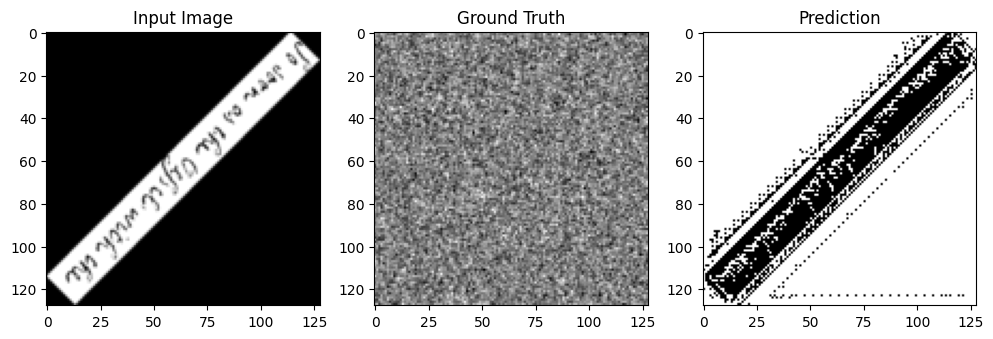

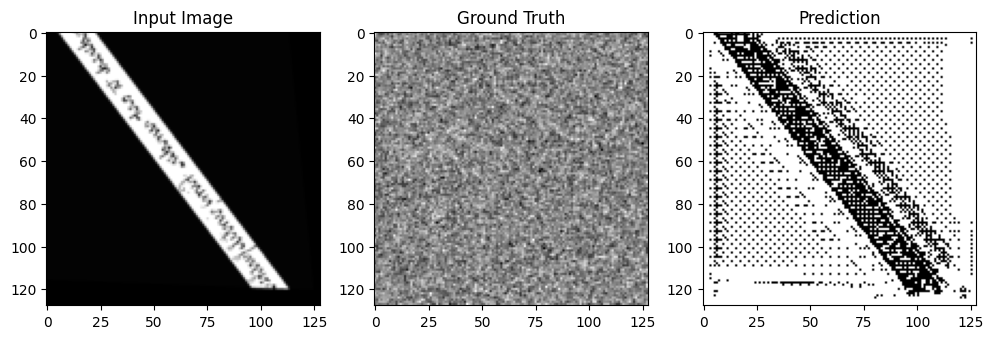

In [46]:
import matplotlib.pyplot as plt

for i in range(len(images)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i].cpu().permute(1, 2, 0), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(preds[i].cpu().squeeze(), cmap='gray')
    plt.show()


In [47]:
import torch
import numpy as np
from PIL import Image
import cv2
from torchvision import transforms
import pickle

def segment_text_regions_and_crop(train_loader, unet, transform, device):
    cropped_images = []
    targets = []  # Store corresponding targets (e.g., transcriptions or labels)

    for images, masks, labels in train_loader:
        images = images.to(device)

        with torch.no_grad():
            predicted_masks = unet(images)
            predicted_masks = predicted_masks.squeeze(1).cpu().numpy()  # Shape [N, H, W]

        for idx, mask in enumerate(predicted_masks):
            if mask.ndim == 3:
                mask = mask[0]  # Remove extra dimension if necessary

            mask = (mask * 255).astype(np.uint8)
            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)

                # Skip invalid bounding boxes
                if w == 0 or h == 0:
                    continue

                cropped_image = images[idx].cpu().numpy()[y:y+h, x:x+w]

                # Ensure cropped image is valid
                if cropped_image.size == 0:
                    continue

                # Resize cropped image to (128, 128)
                cropped_image_resized = cv2.resize(cropped_image[0], (128, 128))  # Resize the grayscale image to 128x128
                cropped_image_resized = np.expand_dims(cropped_image_resized, axis=0)  # Add channel dimension -> (1, 128, 128)

                # Ensure the image has shape (1, 128, 128)
                if cropped_image_resized.shape != (1, 128, 128):
                    print(f"Warning: Cropped image shape is {cropped_image_resized.shape} at index {idx}, resizing...")
                    cropped_image_resized = cv2.resize(cropped_image_resized[0], (128, 128))
                    cropped_image_resized = np.expand_dims(cropped_image_resized, axis=0)

                cropped_images.append(cropped_image_resized)

                # Optionally add a corresponding target (e.g., transcription or label)
                targets.append(labels[idx])  # Replace with appropriate target

    return cropped_images, targets

# Preprocess the image with the transform (resize, grayscale, normalize)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fit model input size
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for single-channel (grayscale)
])

# Now you can call the function and pass `train_loader` (DataLoader object)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet = UNet(in_channels=1, out_channels=1).to(device)

# Load the model weights
unet.load_state_dict(torch.load("unet_text_region_detection.pth", map_location=device, weights_only=True))
unet.eval()  # Set the model to evaluation mode

# Assuming train_loader is already defined (as DataLoader object)
cropped_images, targets = segment_text_regions_and_crop(train_loader, unet, transform, device)

# Save the segmented images for later processing (e.g., OCR)
with open('segmented_images.pkl', 'wb') as f:
    pickle.dump(cropped_images, f)


In [48]:
# Load the segmented images from the file
with open('segmented_images.pkl', 'rb') as f:
    segmented_images = pickle.load(f)


In [49]:
import matplotlib.pyplot as plt
import torch

def display_batch(loader):
    """
    Display a batch of images from a DataLoader.

    Parameters:
        loader (DataLoader): DataLoader object containing the dataset.
    """
    # Get a single batch from the loader
    for batch in loader:
        images, _ = batch  # Unpack the batch, ignore labels
        batch_size = len(images)

        # Set up the plot with vertical display (one image per line)
        fig, axes = plt.subplots(batch_size, 1, figsize=(5, 2 * batch_size))  # Adjust the size vertically

        # Ensure axes is iterable for single image batch
        if batch_size == 1:
            axes = [axes]

        for idx, image in enumerate(images):
            # Handle grayscale images (single channel)
            if len(image.shape) == 3 and image.shape[0] == 1:  # Shape: (1, H, W)
                image = image.squeeze(0)  # Remove channel dimension

            # Convert to numpy for visualization
            if isinstance(image, torch.Tensor):
                image = image.numpy()

            # Display the image, with gray colormap if grayscale
            cmap = 'gray' if len(image.shape) == 2 else None
            axes[idx].imshow(image, cmap=cmap)
            axes[idx].axis('off')  # Remove axes for cleaner display

        # Adjust layout and display
        plt.tight_layout()
        plt.show()
        break  # Display only the first batch


In [50]:
import string

# Generating all printable ASCII characters (from 32 to 126 inclusive)
ascii_chars = [chr(i) for i in range(32, 127)]

# Add non-printable but commonly used ASCII characters (e.g., newline '\n')
special_chars = ['\n']

# Combine special and printable characters into the vocabulary
vocab = ['<blank>'] + ascii_chars + special_chars

# Create mapping dictionaries
char_to_index = {char: idx for idx, char in enumerate(vocab)}
index_to_char = {idx: char for idx, char in enumerate(vocab)}

# Print the index of <blank> token and the size of the vocabulary
print(f"Index of <blank>: {char_to_index['<blank>']}")
print(f"Size of vocabulary: {len(vocab)}")





Index of <blank>: 0
Size of vocabulary: 97


In [51]:
def encode_target(target_texts):
    encoded_targets = []  # List to hold encoded target texts (as tensors)
    target_lengths = []   # List to hold lengths of each encoded target text
    unknown_chars = []    # List to hold characters that are not found in the vocabulary

    for text in target_texts:
        text = str(text)  # Ensure text is a string
        encoded_text = []  # List to hold indices for the current text

        for char in text:
            if char in char_to_index:
                # Directly map the character to its index if it exists in vocab
                encoded_text.append(char_to_index[char])
            else:
                # If the character is not found, use <blank> token
                encoded_text.append(char_to_index['<blank>'])
                unknown_chars.append(char)  # Track unknown characters

        # Append the encoded text as a PyTorch tensor of long integers
        encoded_targets.append(torch.tensor(encoded_text, dtype=torch.long))

        # Append the length of the current encoded text
        target_lengths.append(len(encoded_text))

    # Optionally, log unknown characters for debugging purposes
    if unknown_chars:
        print(f"Unknown characters encountered: {set(unknown_chars)}")

    return encoded_targets, target_lengths




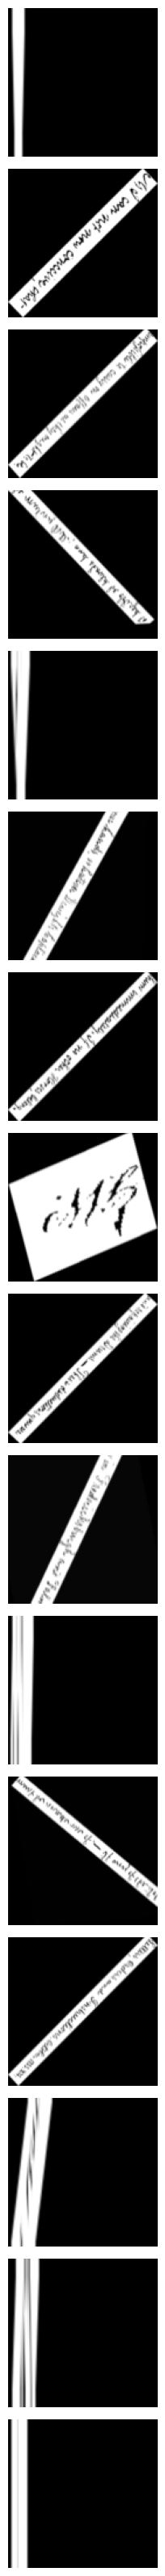

In [52]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CroppedImagesDataset(Dataset):
    def __init__(self, segmented_images, targets, transform=None):
        self.segmented_images = segmented_images
        self.targets = targets
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),  # Resize to 128x128
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.segmented_images)

    def __getitem__(self, idx):
        cropped_image = self.segmented_images[idx]
        target = self.targets[idx]

        # Ensure the image is in (1, H, W) shape
        if cropped_image.ndim == 2:  # Grayscale (H, W)
            cropped_image = np.expand_dims(cropped_image, axis=0)  # Add channel dimension -> (1, H, W)

        # Apply transformations if provided (convert NumPy array to PIL Image before transformation)
        if self.transform:
            cropped_image_resized = self.transform(Image.fromarray(cropped_image[0]))  # Transform directly to tensor

        return cropped_image_resized, target


# Step 1: Define a custom collate_fn
def collate_fn(batch):
    images, targets = zip(*batch)

    # Stack the images to create a batch (torch.stack assumes all images are the same shape)
    images_stack = torch.stack(images)

    # Use the encode_target function to encode the target strings
    encoded_targets, target_lengths = encode_target(targets)

    # Stack the targets (now they're tensors of indices)
    targets_stack = torch.nn.utils.rnn.pad_sequence(encoded_targets, batch_first=True, padding_value=char_to_index['<blank>'])

    return images_stack, targets_stack


# Assuming segmented_images and targets are already defined
dataset = CroppedImagesDataset(segmented_images, targets, transform=transform)

# Create a DataLoader for batching
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Function to display a batch of images and their labels
display_batch(data_loader)

In [53]:
!pip install torchmetrics

In [54]:
class ImagesDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        """
        Args:
            images (list): List of file paths or PIL Image objects.
            targets (list): List of transcription strings (labels).
            transform (callable, optional): Optional transforms to be applied to images.
        """
        self.images = images
        self.targets = targets
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),  # Resize to 128x128
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # If the image is already a PIL Image, skip opening it
        image = self.images[idx]
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert("L")  # Open as grayscale if not already PIL

        # Apply the transform
        if self.transform:
            image = self.transform(image)

        target = self.targets[idx]
        return image, target

# Create a DataLoader for batching

val_dataset = ImagesDataset(val_images, val_transcriptions)
test_dataset = ImagesDataset(test_images, test_transcriptions)

batch_size = 16  # Adjust based on your system's capacity
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [55]:
def validate(model, validation_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            targets, target_lengths = encode_target(labels)
            targets = torch.nn.utils.rnn.pad_sequence(
                targets, batch_first=True, padding_value=char_to_index['<blank>']
            ).to(device)

            logits = model(images)
            logits = torch.clamp(logits, min=-10, max=10)
            input_lengths = torch.full(
                (images.size(0),), logits.size(1), dtype=torch.long
            ).to(device)
            target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
            log_probs = F.log_softmax(logits, dim=-1)

            loss_value = criterion(
                log_probs.permute(1, 0, 2),  # [T, N, C] for CTC
                targets,
                input_lengths,
                target_lengths,
            )
            val_loss += loss_value.item()

    return val_loss / len(validation_loader)

In [56]:
num_classes = len(vocab)
print(num_classes)

97


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.text import WordErrorRate  # WER metric
import time
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Define the device (CUDA if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Feature extractor and OCR model
num_classes = len(vocab)

# Initialize the OCR model with both U-Net and ResNet
ocr_model = OCRModel(num_classes).to(device)

# Loss and optimizer
criterion = nn.CTCLoss(blank=char_to_index['<blank>']).to(device)  # CTC loss
optimizer = optim.Adam(ocr_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


best_val_loss = float('inf')  # Initialize to infinity


# Train the OCR model
def train_ocr_model(model, dataloader, validation_loader, loss, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (images, labels) in enumerate(dataloader):

            # Input validation

            images = images.to(device)

            # Encode targets
            targets, target_lengths = encode_target(labels)
            targets = torch.nn.utils.rnn.pad_sequence(
                targets, batch_first=True, padding_value=char_to_index['<blank>']
            ).to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(images)  # Output shape: [B, W, num_classes]

            # Clamp logits to stabilize training
            logits = torch.clamp(logits, min=-10, max=10)
            # Define lengths
            input_lengths = torch.full(
                (images.size(0),), logits.size(1), dtype=torch.long
            ).to(device)  # Sequence length
            target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)

            # Compute log probabilities for CTC
            log_probs = F.log_softmax(logits, dim=-1)

            # Loss computation with exception handling
            try:
                loss_value = loss(
                    log_probs.permute(1, 0, 2),  # [T, N, C] for CTC
                    targets,
                    input_lengths,
                    target_lengths,
                )
                if torch.isnan(loss_value) or torch.isinf(loss_value):
                    print("NaN or Inf detected in loss. Skipping batch.")
                    continue

                # Backpropagation
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                epoch_loss += loss_value.item()

            except Exception as e:
                print(f"Error during loss computation: {e}. Skipping batch.")
                continue
        model.eval()
        val_loss = validate(model, validation_loader, loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Train Loss: {epoch_loss / len(dataloader):.4f}, Total Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        global best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_ocr_model.pth")
            print("Best model saved!")

        model.train()

# Train the model
train_ocr_model(ocr_model, data_loader, valloader, criterion, optimizer)

# Save model weights after training
torch.save(ocr_model.state_dict(), "final_ocr_model.pth")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Average Train Loss: 2.9772, Total Train Loss: 181.6114, Validation Loss: 15.5395
Best model saved!
Epoch 2/10, Average Train Loss: 2.0670, Total Train Loss: 126.0854, Validation Loss: 16.7895
Epoch 3/10, Average Train Loss: 2.0591, Total Train Loss: 125.6036, Validation Loss: 17.7503
Epoch 4/10, Average Train Loss: 2.0278, Total Train Loss: 123.6932, Validation Loss: 17.2457
Epoch 5/10, Average Train Loss: 1.9538, Total Train Loss: 119.1816, Validation Loss: 17.1473
Epoch 6/10, Average Train Loss: 1.9127, Total Train Loss: 116.6737, Validation Loss: 17.5540
Epoch 7/10, Average Train Loss: 1.8958, Total Train Loss: 115.6417, Validation Loss: 18.6741
Epoch 8/10, Average Train Loss: 1.8753, Total Train Loss: 114.3956, Validation Loss: 19.4676
Epoch 9/10, Average Train Loss: 1.8798, Total Train Loss: 114.6675, Validation Loss: 21.6001
Epoch 10/10, Average Train Loss: 1.8679, Total Train Loss: 113.9397, Validation Loss: 21.6578


In [58]:

# Decode target indices back to text
def decode_target(target):
    return ''.join([index_to_char[idx.item()] for idx in target if idx.item() != char_to_index['<blank>']])

In [63]:
import editdistance

def calculate_cer(pred_texts, target_texts):
    """
    Calculate the Character Error Rate (CER) between predicted and target texts.
    CER = Levenshtein Distance / Number of characters in the target text.
    """
    total_cer = 0
    total_chars = 0

    for pred, target in zip(pred_texts, target_texts):
        # Levenshtein distance
        edit_dist = editdistance.eval(pred, target)
        total_cer += edit_dist
        total_chars += len(target)

    cer = total_cer / total_chars if total_chars > 0 else 0
    return cer

In [73]:
import torch
import torch.nn.functional as F
from torchmetrics import WordErrorRate
from torch.nn.utils.rnn import pad_sequence

def evaluate(model, loader):
    model.eval()
    wer_metric = WordErrorRate()
    temperature =  1 # You can adjust this value based on experimentation
    total_wer = 0  # Variable to accumulate the WER
    total_batches = 0  # Variable to count the number of batches

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Encode the labels using your encode_target function
            targets, target_lengths = encode_target(labels)

            # Pad the targets and move to device
            targets = pad_sequence(targets, batch_first=True, padding_value=char_to_index['<blank>']).to(device)
            target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)  # Convert list to tensor and move to device

            # Forward pass through the model
            logits = model(images)

            # Apply softmax with temperature scaling (logits are of shape [batch_size, seq_len, num_classes])
            probs = torch.softmax(logits / temperature, dim=-1)  # Apply temperature to logits

            # Get the most probable character indices
            pred_indices = torch.argmax(probs, dim=-1)  # shape (batch_size, sequence_length)

            # Convert indices to characters (ensure you have a mapping from indices to characters)
            predicted_texts = []
            for indices in pred_indices:
                predicted_text = ''.join([vocab[i.item()] for i in indices])
                predicted_texts.append(predicted_text)

            # Decode the target labels to text
            target_strings = [decode_target(target) for target in targets]  # Process each target sequence

            # Print out the predictions and targets
            for pred, target in zip(predicted_texts, target_strings):
                print(f"Predicted: {pred}")
                print(f"Ground Truth: {target}")
                print("-" * 50)
                process_transcription_and_save_separately(pred, output_file)

            cer = calculate_cer(predicted_texts, target_strings)
            print(f"CER: {cer:.2f}")

            # Use WER metric (works with strings now)
            wer = wer_metric(predicted_texts, target_strings)
            print(f"WER: {wer.item():.2f}")

# Assuming you have a model and a test loader
evaluate(ocr_model, testloader)  # This would call the evaluate function with your OCR model and test loader


Predicted: eensoor([[[<blank>,,<blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><bl

In [60]:
!pip install jiwer

In [66]:
import torch
import torch.nn.functional as F
from torchmetrics import WordErrorRate
from torch.nn.utils.rnn import pad_sequence
from jiwer import wer


def decode_ctc(logits, char_to_index, index_to_char):
    batch_size = logits.size(0)
    seq_len = logits.size(1)

    if logits.dim() == 2:  # Shape (batch_size, seq_len)
        pred_indices = logits  # Assuming logits are already the predicted class indices
    elif logits.dim() == 3:
        _, pred_indices = logits.max(dim=-1)  # Get indices with highest probability (batch_size, seq_len)
    else:
        raise ValueError("Unexpected logits shape")

    decoded_texts = []
    for batch_idx in range(batch_size):
        text = []
        prev_idx = -1

        for seq_idx in range(seq_len):
            idx = pred_indices[batch_idx, seq_idx].item()  # Convert to Python integer

            # Skip <blank> and consecutive duplicates
            if idx != char_to_index['<blank>'] and idx != prev_idx:
                text.append(index_to_char[idx])  # Convert index to character
            prev_idx = idx

        decoded_texts.append(''.join(text))

    return decoded_texts


def evaluate(model, loader, vocab, char_to_index, index_to_char):
    model.eval()
    wer_metric = WordErrorRate()
    temperature =  1  # You can adjust this value based on experimentation

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Encode the labels using your encode_target function
            targets, target_lengths = encode_target(labels)

            # Pad the targets and move to device
            targets = pad_sequence(targets, batch_first=True, padding_value=char_to_index['<blank>']).to(device)
            target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)  # Convert list to tensor and move to device

            # Forward pass through the model
            logits = model(images)

            # Apply softmax with temperature scaling (logits are of shape [batch_size, seq_len, num_classes])
            probs = torch.softmax(logits / temperature, dim=-1)  # Apply temperature to logits


            # Decode the logits using CTC decoding
            decoded_texts = decode_ctc(probs, char_to_index, index_to_char)  # Using decode_ctc function

            # Decode the target labels to text
            target_strings = [decode_target(target) for target in targets]  # Process each target sequence

            # Print out the predictions and targets
            for pred, target in zip(decoded_texts, target_strings):
                print(f"Predicted: {pred}")
                print(f"Ground Truth: {target}")
                print("-" * 50)

            cer = calculate_cer(decoded_texts, target_strings)
            print(f"CER: {cer:.2f}")

            # Use WER metric (works with strings now)
            error_rate = wer(decoded_texts, target_strings)
            print(f"WER: {error_rate:.2f}")

# Assuming you have a model, test loader, vocab, char_to_index, and index_to_char
evaluate(ocr_model, testloader, vocab, char_to_index, index_to_char)  # This would call the evaluate function with your OCR model and test loader


Predicted: ensor([,
Ground Truth: 302-31 t-h-a-t|I|m-a-y|g-i-v-e|o-r-d-e-r-s|a-c-c-o-r-d-i-n-g-l-y-s_pt
--------------------------------------------------
Predicted: ensor([,
Ground Truth: 270-12 O-c-t-o-b-e-r|s_2-s_6th-s_pt|s_GW
--------------------------------------------------
Predicted: ensor([,
Ground Truth: 304-01 s_3-s_0-s_4-s_pt|L-e-t-t-e-r-s|O-r-d-e-r-s|a-n-d|I-n-s-t-r-u-c-t-i-o-n-s-s_pt|D-e-c-e-m-b-e-r|s_1-s_7-s_5-s_5-s_pt
--------------------------------------------------
Predicted: ensor([,
Ground Truth: 274-09 i-n|t-h-e|F-o-r-t|a-r-e|f-u-l-l-s_pt|A-s|S-e-r-g-e-a-n-t|W-i-l-s_mi
--------------------------------------------------
Predicted: ensor([,
Ground Truth: 308-20 t-o|s-e-n-d|a|S-e-r-g-e-a-n-t-s_cm|a-n-d|o-n-e|o-r|t-w-o|t-r-u-s-t-y|m-e-n
--------------------------------------------------
Predicted: ensor([,
Ground Truth: 271-18 A-m-m-u-n-i-t-i-o-n-s_cm|s_et-c-s_pt|f-o-r|t-h-e|F-o-r-t-s_sq|w-h-e-r-e|y-o-u|w-i-l-l
--------------------------------------------------
Predict

In [72]:
output_file = "/content/drive/My Drive/all.txt"

def process_transcription_and_save_separately(transcription_output, output_file):
    """
    Save all transcription outputs into a single text file.

    Args:
        transcription_output (list): A list of transcription strings.
        output_file (str): The file where all transcriptions will be saved.
    """
    with open(output_file, 'w') as f:
        for idx, line in enumerate(transcription_output):
            f.write(line)
    print(f"All transcriptions saved to {output_file}")
